## Inversion einer Gleichstrom-Geoelektrik-Messung 

Dieses Programm invertiert eine Widerstandstiefenverteilung für gemessene Sondierungskurven.
 Die prinzipielle Vorgehensweise der Inversion wird im Folgenden kurz erklärt. 

Grundlage einer jeden Inversion sind eine Reihe von Messdaten *d* (in diesem Fall die Sondengeometrie sowie die Spannungs- und Stromstärkewerte) sowie ein Startmodell *m* (Widerstands-Tiefenverteilung als erste Annahme). Das Startmodell sollte per Hand gewählt werden. In der Gleichstromgeoelektrik geht dies recht einfach anhand der Form der Sondierungskurve. 

Anhand des Startmodells wird eine *Vorwärtsrechnung* durchgeführt, d.h. es wird  für dieses Modell eine (synthetische) Sondierungskurve berechnet.  Anschließend wird der Unterschied zwischen der gemessenen Sondierungskurve und der synthetischen Sondierungskurve (Modellantwort) berechnet. Dieser Fehler wird häufig als *misfit* bezeichnet und mit $\delta$ abgekürzt. 

An diesem Punkt beginnt die eigentliche Inversion. Zum aktuellen Modell *m*  wird eine kleine (in diesem Fall zufällige) Modellveränderung $\Delta$m addiert, so dass ein neues Modell m$_{new}$ daraus entsteht. Auch für dieses Modell wird eine Vorwärtsrechnung durchgeführt (d.h. eine sythetische Sondierungskurve berechnet) und der Unterschied/*misfit* $\delta_{new}$ zwischen den Daten und der Modellantwort bestimmt.

Anschließend werden $\delta_{new}$ und $\delta$ verglichen. Hier gibt es zwei Möglichkeiten. 

- 1. $\delta_{new}$ ist kleiner als $\delta$, d.h. das neue Modell passt die Messdaten besser an, als das alte. Es wird deshalb das neue Modell übernommen und das alte Modell verworfen. Die Inversion wird fortgeführt, in dem das neue Modell weiter verändert wird (Modellupdate).
- 2. $\delta_{new}$ ist größer als $\delta$, d.h. das neue Modell passt die Messdaten schlecher an. Dann wird das neue Modell verworfen und das alte Modell wird erneut einem zufälligen Modellupdate unterzogen.

Auf diese Weise kann die Modellanpassung auschließlich besser werden oder gleich bleiben. 

Dieser Kreislauf wird eine *Iteration* der Inversion genannt. Diese Schritte werden so lange wiederholt, bis eine maximale Anzahl von Iterationen, die zuvor definiert werden muss, erreicht ist. Dann wird das letzte Modell als  finales Modell gespeichert, welches die Daten bestmöglich anpasst. 

Das folgende Organigramm fasst die wichtigsten Schritte der Inversion zusammen. 

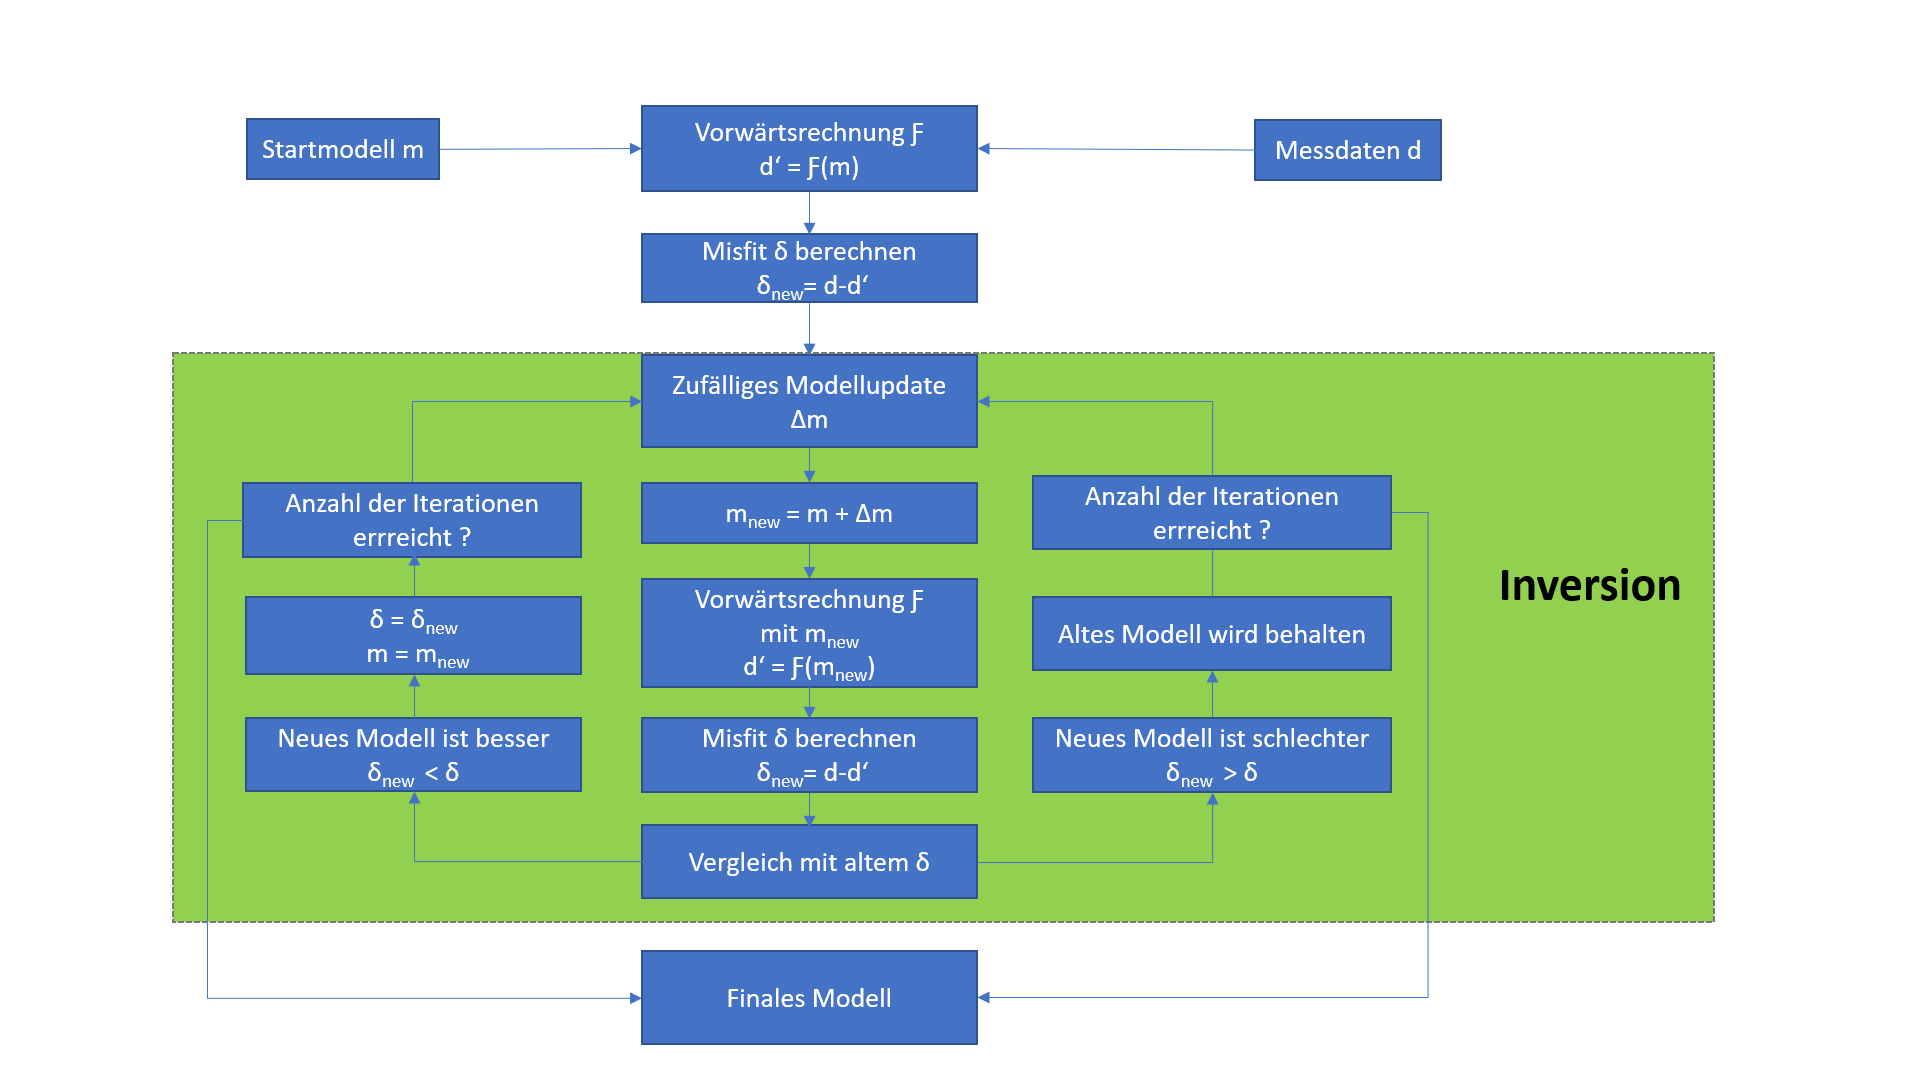

#### Geben Sie in die folgende Codezelle ihre gemessenen Werte für L/2 und den scheinbaren spezifischen Widerstand ein. Führen Sie anschließend die Zelle aus. 

Formatbeispiel: a = 10, L/2 = [10,20,30,40] , rho_a = [10,20,30,40]

In [ ]:
'###############################################'
'Geben Sie in diese Zelle Ihre Messwerte ein:'
'###############################################'

# Abstand der Potentialsonden
a = 1

# halbe Auslagenlänge
L_halbe = [  ]

# scheinbarer spezifischer Widerstand
rho_a = [  ]

print('Fertig. Definieren Sie als nächstes Ihr Startmodell.')


#### Geben Sie in die folgende Codezelle die Schichtmächtigkeiten und spezifisch elektrischen Widerstände für Ihr Startmodell ein. Schätzen Sie dieses aus der von Ihnen geplotteten Sondierungskurve ab. 

Formatbeispiel für ein Dreischichtmodell: rho_start = [200, 75, 300 ], d_start = [ 2, 10] 

In [ ]:
'###############################################'
'Geben Sie in diese Zelle Ihr Startmodell ein:'
'###############################################'

# Startmodell: 
# (Achtung: die unterste Schicht wird als Halbraum betrachtet, 
# deshalb muss für die Schichtmächtigkeit ein Wert weniger angegeben werden,
# als für den spez. elektr. Widerstand)

# spezifisch elektrischer Widerstand 
rho_start = [  ]; 

# Schichtmächtigkeit
d_start = [ ]; 

print('Fertig. Für das Inversionsergebnis führen Sie die nächste Zelle aus.')

In [ ]:
import numpy as np
import scipy.special as scp
import matplotlib.pyplot as plt
import time
import math
from Inversion import *

d_max = 50

# Messwerte
# Halber Abstand der Einspeisesonden i 
L_halbe = np.array(L_halbe)
# Scheinbarer spezifischer Widerstand in Ohm Meter
rho_a = np.array(rho_a)

#-----------------------------------
# Startmodell original
rho_start = np.array(rho_start); 
d_start = np.array(d_start); 
#-----------------------------------

G=np.multiply(math.pi,(np.square(L_halbe)-np.square(a/2)))

# Inversionparameter
dx = .025 # Parameter für das numerische Lösen des Intergrals (am besten so lassen)
n_max = 10; # Parameter für das numerische Lösen des Intergrals (am besten so lassen)
fac = .15; # kontrolliert wie groß ein einzelnes Modellupdate sein soll
it_max = 400; # Anzahl der Modelle pro Iteration, die getestet werden
n_realisation = 5 ; # Wie viele Equivalenzmodelle sollen berechnet werden ? 


# Inversion wird gestartet 

data = np.column_stack((L_halbe,G,rho_a))
start_model = np.concatenate([rho_start,d_start])
bessel = precompute_bessel_function(data[:,0],dx,n_max)

plt.figure(figsize=(20,40))
#fig, ax = plt.subplots(2, 2)
#fig.tight_layout(h_pad=2)
plt.subplot(4,2,1)
plot_sondierungskurve(L_halbe,rho_a)


plt.subplot(4,2,3)
history = invert_model(n_realisation,it_max,start_model,data,dx,n_max,fac)

plt.subplot(4,2,4)
plot_start_model(rho_start,d_start,d_max)

# Find best model 
plt.subplot(4,2,5)
which_model = np.argmin(history[:,np.size(history,1)-1])

# Plot best model

rho_final = history[which_model,range(0,np.size(history,1)//2)]; 
d_final = history[which_model,range(np.size(history,1)//2,np.size(history,1)-1)]; 
rho_aM = forward_model_1(rho_final,d_final,data[:,0],bessel,dx,n_max)
plot_single_model(data,rho_aM)

plt.subplot(4,2,6)
plot_final_model(history)

# Plot Equivalent-Models
plt.subplot(4,2,7)
plot_equivalent_models(history)

print('  ')
print(' ************** ')
print('Best Fit Model:')
print('spez. Widerstand: ',rho_final)
print('Schichtmächtigkeit: ', d_final)    
       
print('Fertig')
    